# Predict stock prices  with Long short-term memory (LSTM)

This simple example will show you how LSTM models predict time series data. Stock market data is a great choice for this because it's quite regular and widely available via the Internet. 

## Install requirements
We install Tensorflow 2.0 with GPU support first

In [27]:
!pip install tensorflow pandas-datareader -q

In [28]:
!pip install pydot pydot-ng -q

In [29]:
!pip install yfinance pandas_datareader -Uq --no-cache-dir

## Introduction

LSTMs are very powerful in sequence prediction problems. They can store past information.

## Loading the dataset
I use pandas-datareader to get the historical stock prices from Yahoo! finance. For this example, I get only the historical data till the end of *training_end_data*.  

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [31]:
import numpy as np #python library for scientific computing
import pandas as pd #python library for data manipulation and analysis
import matplotlib.pyplot as plt #python library for charting
from pandas_datareader import data as pdr #extract data from internet sources into pandas data frame
import yfinance as yf
import tensorflow as tf

# yf.pdr_override()
# data = pdr.get_data_yahoo('^DJI', start='2006-01-01')
# data2 = pdr.get_data_yahoo('MSFT', start='2006-01-01')
# data3 = pdr.get_data_yahoo('AAPL', start='2006-01-01')
# data4 = pdr.get_data_yahoo('BB.TO', start='2006-01-01')

# ax = (data['Close'] / data['Close'].iloc[0] * 100).plot(figsize=(15, 6))
# (data2['Close'] / data2['Close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))
# (data3['Close'] / data3['Close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))
# (data4['Close'] / data4['Close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))

# plt.legend(['Dow Jones', 'Microsoft', 'Apple', 'Blackberry'], loc='upper left')
# plt.show()

In [32]:
tickers = 'IBM'

start_date = '1980-12-01'
end_date = '2018-12-31'

yf.pdr_override()
stock_data = pdr.get_data_yahoo(tickers, start_date)

[*********************100%***********************]  1 of 1 completed


In [33]:
stock_data_len = stock_data['Close'].count()
print(f'Read in {stock_data_len} stock values')

Read in 10722 stock values


In [34]:
close_prices = stock_data.iloc[:, 1:2].values
# print(close_prices)

Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices

In [35]:
all_bussinessdays = pd.date_range(start=start_date, end=end_date, freq='B')
print(all_bussinessdays)

DatetimeIndex(['1980-12-01', '1980-12-02', '1980-12-03', '1980-12-04',
               '1980-12-05', '1980-12-08', '1980-12-09', '1980-12-10',
               '1980-12-11', '1980-12-12',
               ...
               '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21',
               '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-27',
               '2018-12-28', '2018-12-31'],
              dtype='datetime64[ns]', length=9936, freq='B')


In [36]:
close_prices = stock_data.reindex(all_bussinessdays)
close_prices = stock_data.fillna(method='ffill')

The dataset is now complete and free of missing values. Let's have a look to the data frame summary:

## Feature scaling

In [37]:
training_set = close_prices.iloc[:, 1:2].values

In [38]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# print(training_set_scaled.shape)

LSTMs expect the data in a specific format, usually a 3D tensor. I start by creating data with 60 days and converting it into an array using NumPy. Next, I convert the data into a 3D dimension array with feature_set samples, 60 days and one feature at each step.

In [39]:
features = []
labels = []
for i in range(60, stock_data_len):
    features.append(training_set_scaled[i-60:i, 0])
    labels.append(training_set_scaled[i, 0])

features = np.array(features)
labels = np.array(labels)

features = np.reshape(features, (features.shape[0], features.shape[1], 1))

Feature tensor with three dimension: features[0] contains the ..., features[1] contains the last 60 days of values and features [2] contains the  ...

## Create the LSTM network
Let's create a sequenced LSTM network with 50 units. Also the net includes some dropout layers with 0.2 which means that 20% of the neurons will be dropped.

In [40]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (features.shape[1], 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1)
])

2023-06-10 06:59:30.995197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-10 06:59:30.996093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-10 06:59:30.997249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [41]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

The model will be compiled and optimize by the adam optimizer and set the loss function as mean_squarred_error

In [42]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [43]:
from time import time
start = time()
history = model.fit(features, labels, epochs = 20, batch_size = 32, verbose = 1)
end = time()

Epoch 1/20


2023-06-10 06:59:31.801552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-10 06:59:31.802982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-10 06:59:31.803989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

334/334 [==============================] - 20s 45ms/step - loss: 0.0050
Epoch 2/20
334/334 [==============================] - 16s 49ms/step - loss: 0.0023
Epoch 3/20
334/334 [==============================] - 16s 49ms/step - loss: 0.0019
Epoch 4/20
334/334 [==============================] - 16s 47ms/step - loss: 0.0017
Epoch 5/20
334/334 [==============================] - 16s 47ms/step - loss: 0.0015
Epoch 6/20
334/334 [==============================] - 17s 52ms/step - loss: 0.0014
Epoch 7/20
334/334 [==============================] - 17s 51ms/step - loss: 0.0013
Epoch 8/20
334/334 [==============================] - 15s 46ms/step - loss: 0.0012
Epoch 9/20
334/334 [==============================] - 19s 57ms/step - loss: 0.0012
Epoch 10/20
334/334 [==============================] - 18s 53ms/step - loss: 0.0010
Epoch 11/20
334/334 [==============================] - 16s 49ms/step - loss: 0.0010
Epoch 12/20
334/334 [==============================] - 16s 48ms/step - loss: 9.0434e-04
Epoch 13

In [44]:
print('Total training time {} seconds'.format(end - start))

Total training time 342.65283203125 seconds


In [45]:
tf.keras.models.save_model(model, 'stocks/1')

2023-06-10 07:05:14.421925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-10 07:05:14.423613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-10 07:05:14.425296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: stocks/1/assets


INFO:tensorflow:Assets written to: stocks/1/assets


In [46]:
testing_start_date = '2019-01-01'
testing_end_date = '2019-04-10'

test_stock_data = pdr.get_data_yahoo(tickers, testing_start_date, testing_end_date)

[*********************100%***********************]  1 of 1 completed


In [47]:
test_stock_data_processed = test_stock_data.iloc[:, 1:2].values


In [48]:
all_stock_data = pd.concat((stock_data['Close'], test_stock_data['Close']), axis = 0)

In [49]:
inputs = all_stock_data[len(all_stock_data) - len(test_stock_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [50]:
X_test = []
for i in range(60, 129):
    X_test.append(inputs[i-60:i, 0])

In [51]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

2023-06-10 07:05:24.599895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-10 07:05:24.600802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-10 07:05:24.602268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 12ms/step


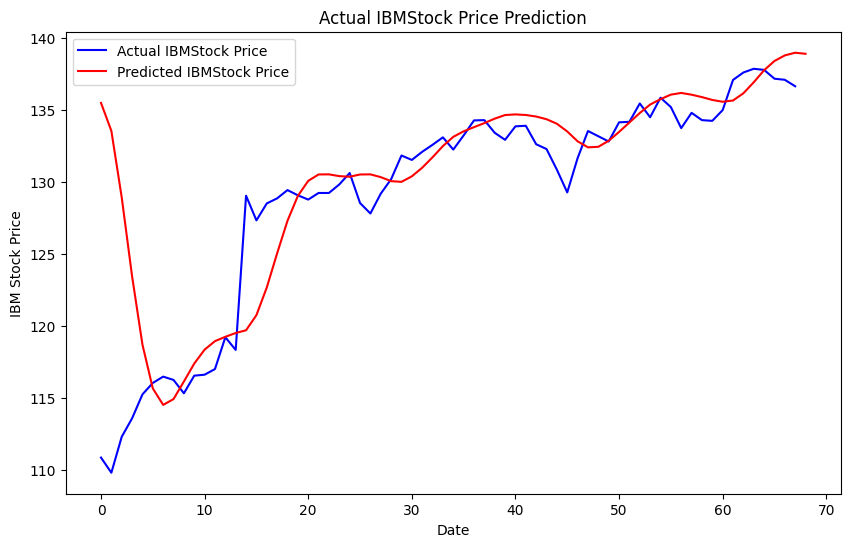

In [52]:
plt.figure(figsize=(10,6))  
plt.plot(test_stock_data_processed, color='blue', label='Actual ' + tickers + 'Stock Price')  
plt.plot(predicted_stock_price , color='red', label='Predicted ' + tickers + 'Stock Price')  
plt.title('Actual ' + tickers + 'Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel(tickers + ' Stock Price')  
plt.legend()  
plt.show()  